<a href="https://colab.research.google.com/github/xiaoyi-yuxiao/python-code-for-FinancialAnalysis-book/blob/master/2020_6_4_chap14_market_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests_html

In [ ]:
pip install yfinance

In [ ]:
pip install yahoo_fin

In [ ]:
pip install requests

In [ ]:
pip install bs4

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from tabulate import tabulate
import datetime as dt#get current date
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from yahoo_fin.stock_info import get_quote_table
import requests
from bs4 import BeautifulSoup
import matplotlib.ticker as mtick
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
def Usr_input():
  previousday = dt.date.today()-dt.timedelta(days=1)# get the date of previous day
  Default_end = previousday.strftime("%Y-%m-%d") # change the format of the default datetime 
  years_ago = dt.date.today()-dt.timedelta(days=(5 * 365) + 30)
  Default_start = years_ago.strftime("%Y-%m-%d")
  Ticker = input('Please enter ticker(Default = JNJ)-->') or 'JNJ'
  Start = input('Enter start date(' + 'Default = 5 Years ago, ' + Default_start + ')-->') or Default_start
  End = input('Enter end date(Default = Yesterday, ' + Default_end + ')-->') or Default_end
  T_interval = input('Enter date interval(1d,1wk,1mo Default = 1mo)-->') or '1mo'
  return Ticker, Start, End, T_interval

In [ ]:
def calculate_ret(stock_a,stock_M,start,end_t,T_interval):
  Stock_price_a = yf.download(stock_a,start=start,end=end_t,interval = T_interval)['Adj Close'].dropna()
  Ret_a = Stock_price_a.pct_change()[1:]
  Stock_price_M = yf.download(stock_M,start=start,end=end_t,interval = T_interval)['Adj Close'].dropna()
  Ret_M = Stock_price_M.pct_change()[1:]
  Ret = pd.DataFrame([Ret_a,Ret_M])
  Ret = Ret.T
  Ret.columns = [stock_a,'SNP']
  return Ret

In [ ]:
def html_beautifulsoup(url):
    response = requests.get(url)
    html = response.content

    #beautifulsoup html will not look like soure
    #review beautifulsoup html to use find and findall
    soup = BeautifulSoup(html,"lxml")
    return soup

#soup_html: soup html is not same as source html
def yahoo_description(soup_html):
    element = soup_html.find('h1',class_='D(ib) Fz(16px) Lh(18px)')
    return element.text  

In [ ]:
(Ticker,macro_start,macro_end,macro_T_interval) = Usr_input()
soup_html = html_beautifulsoup("https://finance.yahoo.com/quote/"  +Ticker)
Ticker_shortN = yahoo_description(soup_html)

Please enter ticker(Default = JNJ)-->JNJ
Enter start date(Default = 5 Years ago, 2015-06-18)-->2015-06-18
Enter end date(Default = Yesterday, 2020-07-15)-->2020-07-15
Enter date interval(1d,1wk,1mo Default = 1mo)-->1mo


In [ ]:
ret = calculate_ret(Ticker,'^GSPC',macro_start,macro_end,macro_T_interval)
ret_M = ret['SNP']
ret_a = ret[Ticker]

ret_Mc = sm.add_constant(ret_M)
results = sm.OLS(ret_a,ret_Mc).fit()
print('                                 Market Model')
print(results.summary())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                 Market Model
                            OLS Regression Results                            
Dep. Variable:                    JNJ   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     38.26
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           6.72e-08
Time:                        15:32:56   Log-Likelihood:                 113.76
No. Observations:                  60   AIC:                            -223.5
Df Residuals:                      58   BIC:                            -219.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    s

In [ ]:
model = ols(Ticker+' ~ SNP',ret).fit()
anova_table = anova_lm(model)
print(anova_table)

            df    sum_sq   mean_sq         F        PR(>F)
SNP        1.0  0.052256  0.052256  38.26166  6.723429e-08
Residual  58.0  0.079213  0.001366       NaN           NaN


Text(0, 0.5, 'JNJ - Johnson & Johnson')

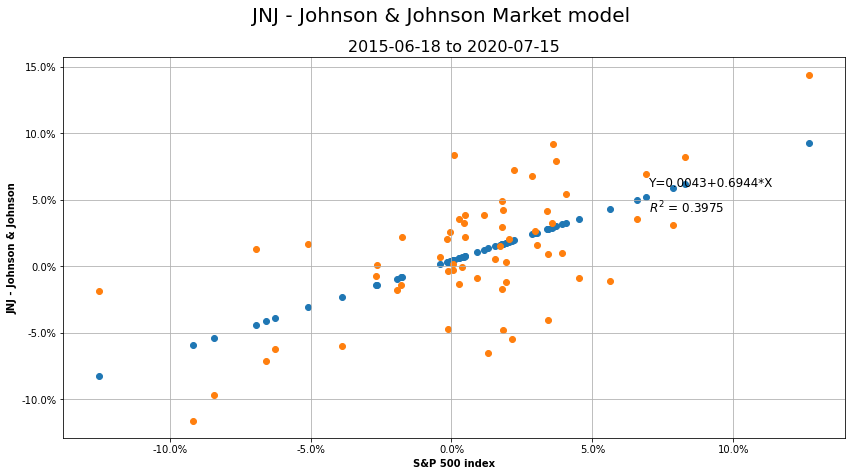

In [ ]:
plt.figure(figsize=(14,7))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
(a,b) = results.params
R_sq = results.rsquared
predict = a+np.multiply(ret_M,b)
plt.scatter(ret_M*100,predict*100)
plt.scatter(ret_M*100,ret_a*100)
plt.text(7, 6, 'Y={:.4f}+{:.4f}*X'.format(a,b), fontsize=12)
plt.text(7, 4, r'$R^2$ = {:.4f}'.format(R_sq), fontsize=12)
plt.suptitle(Ticker_shortN+' Market model',fontsize=20)
plt.title(macro_start+' to '+macro_end,fontsize = 16)
plt.grid(True)
plt.xlabel('S&P 500 index',fontweight='bold')
plt.ylabel(Ticker_shortN,fontweight='bold')

In [ ]:
a=get_quote_table(Ticker , dict_result = True)
a = pd.DataFrame(a, index=[0])
a = a.T
a.columns = ['Value']
print(a)

                                    Value
1y Target Est                      164.24
52 Week Range             109.16 - 157.00
Ask                          147.35 x 800
Avg. Volume                   7.78186e+06
Beta (5Y Monthly)                     0.7
Bid                         147.32 x 3100
Day's Range               146.68 - 148.90
EPS (TTM)                            6.41
Earnings Date                Jul 16, 2020
Ex-Dividend Date             May 22, 2020
Forward Dividend & Yield     4.04 (2.73%)
Market Cap                       387.517B
Open                               148.68
PE Ratio (TTM)                      22.94
Previous Close                     148.26
Quote Price                           147
Volume                        3.39033e+06


In [ ]:
#print data set for market model.
Ret = ret
Ret.columns = [Ticker_shortN,'S&P 500']
pd.options.display.float_format = '{:.4f}'.format
print(Ret)

            JNJ - Johnson & Johnson  S&P 500
Date                                        
2015-08-01                  -0.0622  -0.0626
2015-09-01                   0.0009  -0.0264
2015-10-01                   0.0823   0.0830
2015-11-01                   0.0021   0.0005
2015-12-01                   0.0221  -0.0175
2016-01-01                   0.0167  -0.0507
2016-02-01                   0.0074  -0.0041
2016-03-01                   0.0359   0.0660
2016-04-01                   0.0359   0.0027
2016-05-01                   0.0054   0.0153
2016-06-01                   0.0841   0.0009
2016-07-01                   0.0324   0.0356
2016-08-01                  -0.0470  -0.0012
2016-09-01                  -0.0035  -0.0012
2016-10-01                  -0.0181  -0.0194
2016-11-01                  -0.0404   0.0342
2016-12-01                   0.0423   0.0182
2017-01-01                  -0.0170   0.0179
2017-02-01                   0.0791   0.0372
2017-03-01                   0.0259  -0.0004
2017-04-01

Download the file to local

In [ ]:
# save data set to 'downloads' folder
Ret.to_csv('chapter14_Market_model_' + Ticker + '.csv') 
files.download('chapter14_Market_model_' + Ticker + '.csv')
print ("The chapter14_Market_model_" + Ticker + "'.csv' file was downloaded to your 'Downloads' folder.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The chapter14_Market_model_JNJ'.csv' file was downloaded to your 'Downloads' folder.


Save file to google Drive

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#You will need to clink the link below to login to your account and then paste the password on the blank.
#The following will print out the current file you have on Drive, pick one folder you want and paste the id below
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

The id_ below was setup to be 'Colab Notebooks' 

In [ ]:
file = drive.CreateFile({'parents':[{u'id': '1hc7tCMBD_kCQFAa-KKkSiF_DyLduSc5e'}]})
file.SetContentFile('Market_model.csv')
file.Upload()